<a href="https://colab.research.google.com/github/lstival/mo443/blob/main/T3/T3_MO443.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Lib to work with vectors
import numpy as np

#Image manipulation
import cv2

#Lib to plot images
import matplotlib.pyplot as plt

#Lib to coun values
from collections import Counter

#Lib to create the progress bar
from tqdm import tqdm

#Lib to define the argument when call the file
import argparse

Vídeos
https://www.ic.unicamp.br/~helio/videos_mp4/

In [2]:
# # Paramets to read the origin image and text file
# parser = argparse.ArgumentParser(description='Summarization')
# parser.add_argument('--input_video', default='baboon.png', help='Name of the input Image')
# parser.add_argument('--out_image', default='output_image.png', help='Name to save the image with halftoning')
# parser.add_argument('--mask', default='mask_Stucki', help='Define how mask will be used to halftoning, possibles values \
#                                                         [mask_Stucki, mask_Sierra, mask_Burkes, mask_Jarvis, mask_Stevenson, \
#                                                         mask_Steinberg]. For default the script use mask_Stucki')
# parser.add_argument('--zigzag', default='True', help='Define if the result will use ZigZag method')

# # Parse the paraments passed to the script
# opt = parser.parse_args()

In [3]:
#Classico
list_videos = ['xylophone.mp4', 'umn.mp4', 'toy.mp4', 'news.mpg', 'lisa.mpg'
'indi009.mpg', 'UGS09.mpg', '36553.mpg', '08401.mpg', '08386.mpg', '08024.mpg']

#lisa nao funciona

# video_url = "https://www.ic.unicamp.br/~helio/videos_mp4/indi009.mpg"

select_video = list_videos[0]

video_url = f"https://www.ic.unicamp.br/~helio/videos_mp4/{select_video}"

#https://www.ic.unicamp.br/~helio/disciplinas/MO443/trabalho3.pdf

## Load the video

In [4]:
video = cv2.VideoCapture(video_url)

In [5]:
video_frames = []
while(True):
    # Capture frame-by-frame
    ret, frame = video.read()
    #print cap.isOpened(), ret
    if frame is not None:
        # Display the resulting frame
        video_frames.append(frame)
    else:
        break

In [6]:
def convert2gray(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray_image

In [7]:
def convert2BGR(image):
    color_image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    return color_image

In [8]:
def convert2HSV(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    return hsv_image

In [9]:
def convert_from_HSV(image):
    color_image = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)
    return color_image

In [10]:
hsv_video_frames = np.array(list(map(convert2gray, video_frames)))

In [11]:
# gray_video_frames = hsv_video_frames[:,:,:,2]
gray_video_frames = hsv_video_frames

## Diferença entre pixels


In [12]:
def diff_betweens_pixels(gray_video_frames, T1=64, T2_tax = 0.8):

    #List with the diff between the frames
    list_pixels_diff = []

    #List with indexs where the pixel pass the secong threshould
    list_over_T2 = []

    for frame in tqdm(range(len(gray_video_frames)-1)):

        actual = gray_video_frames[frame]
        next =  gray_video_frames[frame+1]
    
        list_pixels_diff.append(np.unique((actual - next) > T1, return_counts=True)[1][1])
    
    T2 = int(max(list_pixels_diff) * T2_tax)

    for diff_pixel in range(len(list_pixels_diff)):

        if list_pixels_diff[diff_pixel] > T2:
                list_over_T2.append(diff_pixel)

        # plot_hist_diff(list_pixels_diff, T2)

    return list_over_T2, T2, list_pixels_diff

## Diferença entre Blocos

In [13]:
def diff_betweens_boxes(gray_video_frames, T1_limiar=2, T2_limit=0.9, box_size=8):
    #Limiar to MSE
    H = gray_video_frames.shape[1] / box_size
    W = gray_video_frames.shape[2] / box_size

    T1 = H / W * T1_limiar
    
    # T2 = len(gray_video_frames) * T2_limit

    #List of frames that transpase the threshould T1
    list_pixels_diff = []

    #Loop in each frame
    for frame in tqdm(range(len(gray_video_frames)-1)):
        #Loop in rows
        for row in range(int(gray_video_frames[frame].shape[0]/box_size)):
            #Loop in collumns
            for col in range(int(gray_video_frames[frame].shape[1]/box_size)):
                
                #Indicies of liit of boxes
                nxt_row = row+box_size
                nxt_col = col+box_size

                #Get the box of actual frame and next, cast them in int to subtract
                actual_frame = gray_video_frames[frame, row:nxt_row, col:nxt_col].astype(int)
                next_frames = gray_video_frames[frame+1, row:nxt_row, col:nxt_col].astype(int)

                #Calculate MSE between the boxs
                norm = (1/(box_size*box_size))
                box_diff =  norm * (np.sum(np.abs(actual_frame - next_frames) ** 2))

                if box_diff > T1:
                    list_pixels_diff.append(frame)

    #List with diff pixel bigger than T2
    list_diff_pixels_MSE = []
    dict_pixels_diff = Counter(list_pixels_diff)

    T2 = max(dict_pixels_diff.values())*T2_limit

    #Loop to count how many boxes each frame have with diff.
    for disct_frame, value in dict_pixels_diff.items():
        if value > T2:
            list_diff_pixels_MSE.append(disct_frame)

    #Plot the distribution of MSE in frames
    # plot_hist_diff(np.array(list(dict_pixels_diff.values())), T2)

    return list_diff_pixels_MSE, T2, np.array(list(dict_pixels_diff.values()))

## Diferença entre histogramas

In [14]:
def diff_betweens_histogram(gray_video_frames):
    #Bins amount
    histSize = 256

    #List with de difference betweeen the histogram
    dif_hist = []

    #Factor of std
    sigma = 2

    #Loop for each frame in the video
    for frame in tqdm(range(len(gray_video_frames)-1)):
        actual = np.histogram(gray_video_frames[frame], np.arange(histSize))[0]
        next = np.histogram(gray_video_frames[frame+1], np.arange(histSize))[0]

        #Save the absulute diference
        dif_hist.append(sum(abs(actual-next)))

    dif_hist = np.asarray(dif_hist)
    T1 = round(np.mean(dif_hist) + (np.std(dif_hist) * sigma))

    frames_over_t1 = []
    for i in range(len(dif_hist)):
        if dif_hist[i] > T1:
            frames_over_t1.append(i)

    # plot_hist_diff(dif_hist, T1)

    return frames_over_t1, T1, dif_hist

## Mapas de bordas

In [15]:
# cv2.Canny(img,limiar_inferior, limiar_superior, tamanho_kernel)

In [16]:
def diff_edge_maps(gray_video_frames, down_limit = 30, up_limite = 90, T1_limiar = 0.98):

    edges_diffences = []

    for frame in tqdm(range(len(video_frames)-1)):

        actual = cv2.Canny(video_frames[frame],down_limit, up_limite)
        next = cv2.Canny(video_frames[frame+1],down_limit, up_limite)

        edges_diffences.append(np.sum(abs(actual-next)))

    T1 = int(max(edges_diffences) * T1_limiar)

    frames_over_T1 = []
    for frame_diff in range(len(edges_diffences)):
        if edges_diffences[frame_diff] > T1:
            frames_over_T1.append(frame_diff)

    # plot_hist_diff(edges_diffences, T1)

    return frames_over_T1, T1, edges_diffences

## Tools

In [17]:
#List of methods to find key frames
avalible_methods = [diff_betweens_pixels,
                    diff_betweens_boxes,
                    diff_betweens_histogram,
                    diff_edge_maps]

In [18]:
#Method to plot the graphs
def plot_hist_diff(ax, list_pixels_diff, T2, function_name):
    print(function_name)
    ax.plot(np.arange(len(list_pixels_diff)), list_pixels_diff)
    ax.hlines(T2, 0, len(video_frames), colors='red', linestyles='solid')
    ax.set_title(f"Result of {function_name}")
    ax.set_xlabel("Nº do frame")
    ax.set_ylabel("Qnt. de pixels com diferença superior ao limiar")

In [19]:
#Plot a hist for each metric used
def plot_all_hist(list_print):
    fig, axs = plt.subplots(len(list_print), figsize=(15,15))
    fig.tight_layout(h_pad=5, w_pad=5)
    for idx_result, plot_list in enumerate(list_print):
        plot_hist_diff(axs[idx_result],
                    plot_list[0],
                    plot_list[1],
                    plot_list[2])
    fig.savefig("histrograms.png")

## Selecionando *Key frames*

In [20]:
def get_colorfull_frames(list_of_frames, number_of_repeats=50):

    frames = np.array(video_frames)[list_diff_pixels]
    print(frames.shape)

    colorful_video_frames = np.repeat(frames, 50, axis=0)

    return colorful_video_frames

In [21]:
def emsemble_mapping(gray_video_frames, threshold=2):

    #List with all frames of the methods
    all_key_frames = []
    list_print = []

    #Loop to execute all methods and save the frames selecteds
    for method in avalible_methods:

        #Call the method and save the information
        list_diff_pixels, threshould, plot_values = method(gray_video_frames)

        #Add values to facility the plot
        list_print.append([plot_values, threshould, method.__name__])

        #Save the values for comparation and make the summary video
        all_key_frames.extend(list_diff_pixels)

    #Get the most selected frames
    key_frames = np.unique(all_key_frames)[np.unique(all_key_frames, 
                                        return_counts=True)[1] >= threshold]

    #Avoid return none frame
    if key_frames == []:
        key_frames = emsemble_mapping(gray_video_frames, threshold-1)
    
    #Return the frames that apears more or equal the limiar
    return key_frames, list_print

In [22]:
# list_diff_pixels, threshould = diff_betweens_pixels(gray_video_frames)

# list_diff_pixels, threshould = diff_betweens_boxes(gray_video_frames, box_size=8)

# list_diff_pixels, threshould = diff_betweens_histogram(gray_video_frames)

# list_diff_pixels, threshould = diff_edge_maps(gray_video_frames)

list_diff_pixels, list_print = emsemble_mapping(gray_video_frames, threshold=2)

#Get the sequencia of color full frames
colorful_video_frames = get_colorfull_frames(list_diff_pixels)

100%|██████████| 140/140 [00:00<00:00, 252.05it/s]

(2, 240, 320, 3)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


diff_betweens_pixels
diff_betweens_boxes
diff_betweens_histogram
diff_edge_maps


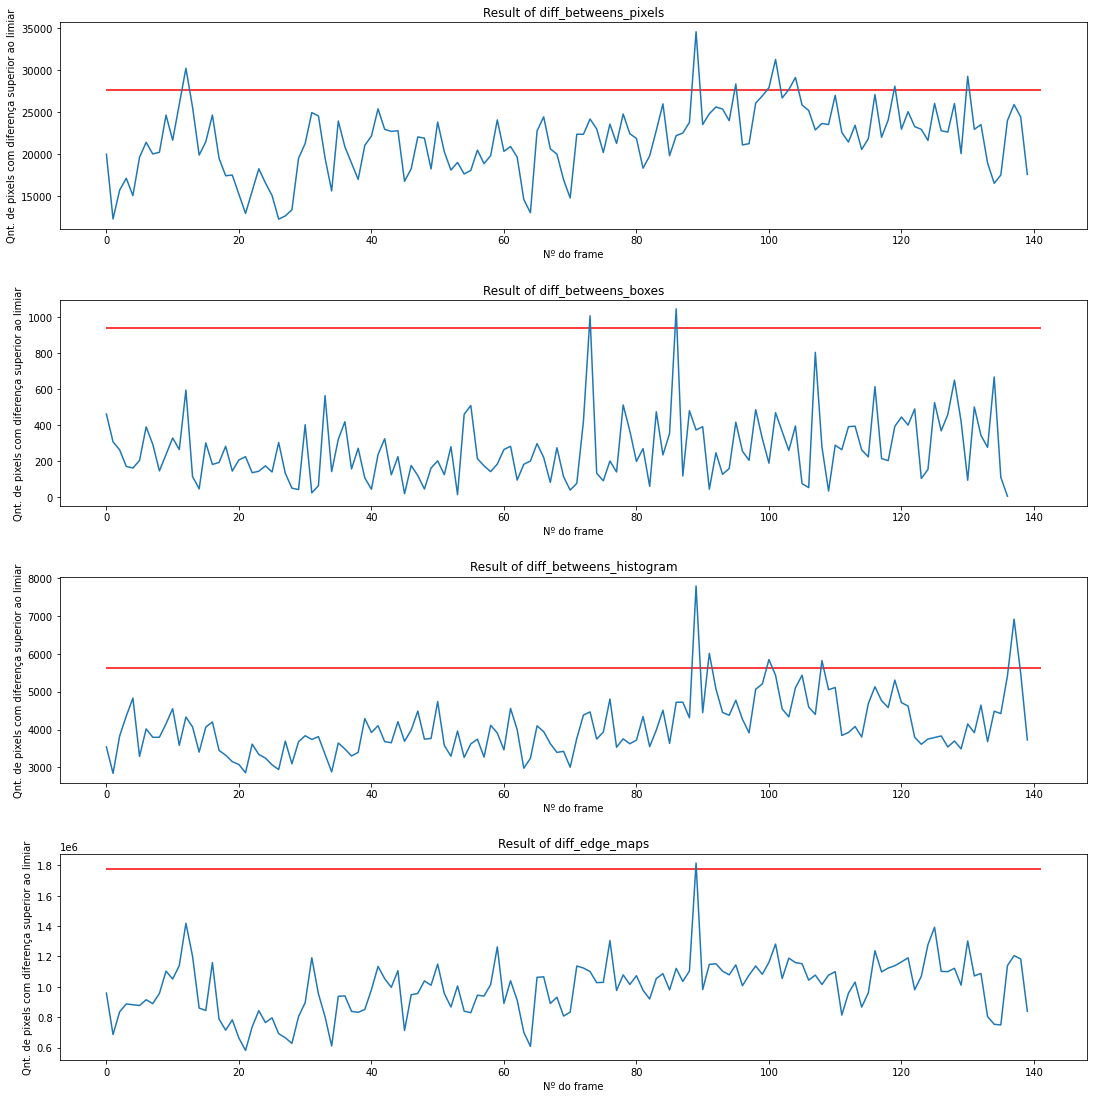

In [23]:
#Loop to plot all values of each metric
plot_all_hist(list_print)

In [24]:
def save_video(colorful_video_frames, video_name='summary_video'):

    size = video_frames[0].shape

    fps = 25
    out = cv2.VideoWriter(f'{video_name}.mp4', 
                          cv2.VideoWriter_fourcc(*'mp4v'),
                          fps,
                          (size[1], size[0]))

    for i in range(len(colorful_video_frames)):
        data = colorful_video_frames[i]
        out.write(data)
    out.release()

In [25]:
save_video(colorful_video_frames)